# DFAnalyzer Simple Example

This notebook will guide you to load a trace file generated by DFTracer and analyze the trace events using Dask.

In [1]:
%load_ext autoreload
%autoreload 2

## System imports for the notebook

In [2]:
import os
from pathlib import Path
import sys
import yaml
import json

## We add the analysis code to path so that we can run this in dev mode.

In [3]:
home = os.environ["HOME"]

with open(f"{home}/.dftracer/configuration.yaml", "r") as file:
    dft_yaml = yaml.safe_load(file)
    app_root = dft_yaml["app"]
sys.path.insert(0, app_root)

## Imports for the notebook

This may take some time as it initializes Dask.

In [4]:
# Importing DFAnalyzer
import dfanalyzer

print(dfanalyzer.__file__)
from dfanalyzer.main import (
    DFAnalyzer,
    update_dft_configuration,
    setup_logging,
    setup_dask_cluster,
    reset_dask_cluster,
)

/eagle/MDClimSim/rayandrew/dftracer/dfanalyzer/__init__.py


## Initialize DFAnalyzer Configuration

In this function, we can tune DFAnalyzer for the analysis. For example, we can tune number of workers, connect to existing dask cluster, etc.

In [5]:
def get_conditions_stormer(json_object):
    app_io_cond = (
        "__getitem__" in json_object["name"]
    )  # I/O has that application is issuing
    compute_cond = "compute" in json_object["cat"]
    io_cond = json_object["cat"] in ["POSIX", "STDIO"]
    return app_io_cond, compute_cond, io_cond

In [6]:
dask_run_dir = os.path.join(app_root, "dfanalyzer", "dask", "run_dir")
with open(os.path.join(dask_run_dir, f"scheduler_{os.getenv('USER')}.json"), "r") as f:
    dask_scheduler = json.load(f)["address"]

In [7]:
conf = update_dft_configuration(
    dask_scheduler=dask_scheduler,
    verbose=True,
    workers=4,
    time_granularity=80e6,
    log_file=f"./df_{os.getenv('USER')}.log",
    conditions=get_conditions_stormer,
)

## This methods sets up logging for DFAnalyzer.

This is needed for debugging and progress tracking. All prints seen in the following cells are configured in this method.

In [8]:
setup_logging()

## Setup dask cluster.

In this example, we use Dask Local cluster which will use multiprocessing on the same node where the notebook is running to run its workers.

**NOTE:** If your running on Remote VSCode on a cluster, you can tunnel the port and open it locally.

In [9]:
setup_dask_cluster()

[INFO] [21:08:40] Initialized Client with 16 workers and link http://140.221.112.12:8787/status [/eagle/MDClimSim/rayandrew/dftracer/dfanalyzer/main.py:665]


On clicking the link, you will see a daskboard like this. [Dask Daskboard Image](images/dask-dashboard-load.png)

## Reset Dask Cluster

In case you have an error and want to clean the cluster for fresh analysis. You can run this.

In [10]:
reset_dask_cluster()

[INFO] [21:08:47] Restarting all workers [/eagle/MDClimSim/rayandrew/dftracer/dfanalyzer/main.py:657]


## Load the DFAnalyzer Trace

The DFAnalyzer class take a regex string as input. For example, "{app_root}/examples/dfanalyzer/*.pfw.gz"

In [11]:
analyzer = DFAnalyzer(f"{app_root}/examples/dfanalyzer/test-trace-distributed/*.pfw.gz")

[INFO] [21:08:49] Created index for 16 files [/eagle/MDClimSim/rayandrew/dftracer/dfanalyzer/main.py:366]
[INFO] [21:08:49] Total size of all files are <dask.bag.core.Item object at 0x7f29f833f210> bytes [/eagle/MDClimSim/rayandrew/dftracer/dfanalyzer/main.py:368]
[INFO] [21:08:49] Loading 64 batches out of 16 files and has 848888 lines overall [/eagle/MDClimSim/rayandrew/dftracer/dfanalyzer/main.py:381]
[INFO] [21:08:52] Loaded events [/eagle/MDClimSim/rayandrew/dftracer/dfanalyzer/main.py:423]
[INFO] [21:08:52] Loaded plots with slope threshold: 45 [/eagle/MDClimSim/rayandrew/dftracer/dfanalyzer/main.py:429]


## Analyze the events

1. The dask dataframe is stored at `analyzer.events`. 
2. We can run dask queries on this dataframe.

In [12]:
analyzer.events.head()

,name,cat,pid,tid,ts,te,dur,tinterval,trange,hostname,compute_time,io_time,app_io_time,total_time,filename,phase,size
0,open,POSIX,1075741,2151482,9178,9186,8,<NA>,0.0,x3012c0s7b0n0,<NA>,8,<NA>,8,/dev/shm/shared_memory.PMI.e6389e0f-f55b-400a-...,2,<NA>
1,open,POSIX,1075741,2151482,10815,10821,6,<NA>,0.0,x3012c0s7b0n0,<NA>,6,<NA>,6,/dev/shm/shared_memory.PMI.e6389e0f-f55b-400a-...,2,<NA>
2,__fxstat,POSIX,1075741,2151482,10849,10850,1,<NA>,0.0,x3012c0s7b0n0,<NA>,1,<NA>,1,/dev/shm/shared_memory.PMI.e6389e0f-f55b-400a-...,2,<NA>
3,mmap,POSIX,1075741,2151482,10868,10876,8,<NA>,0.0,x3012c0s7b0n0,<NA>,8,<NA>,8,/dev/shm/shared_memory.PMI.e6389e0f-f55b-400a-...,2,<NA>
4,close,POSIX,1075741,2151482,10902,10903,1,<NA>,0.0,x3012c0s7b0n0,<NA>,1,<NA>,1,/dev/shm/shared_memory.PMI.e6389e0f-f55b-400a-...,2,<NA>


### Summary 

DFAnalyzer supports a summary utility that gives a brief summary of the job and its I/O access behavior.

In [13]:
items = analyzer.summary()
items

[INFO] [21:08:55] Total number of events in the workload are 848856 [/eagle/MDClimSim/rayandrew/dftracer/dfanalyzer/main.py:521]


╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  Allocation    Scheduler Allocation Details                                                                     │
│                ├── Nodes: 2                                                                                     │
│                ├── Processes: 8                                                                                 │
│                ├── Thread allocations across nodes (includes dynamically created threads)                       │
│                │   ├── Compute: 8                                                                               │
│                │   └── I/O: 813                                                                                 │
│                └── Events Recorded: 849K                                                                        │
│  Dataset       Description of Dataset Used                                                                      │
│                └── Files: 13810                                                                                 │
│  I/O Behavior  Behavior of Application                                                                          │
│                ├── Split of Time in application                                                                 │
│                │   ├── Total Time: 381.544 sec                                                                  │
│                │   ├── Overall App Level I/O: 162.443 sec                                                       │
│                │   ├── Unoverlapped App I/O: 15.205 sec                                                         │
│                │   ├── Unoverlapped App Compute: 116.012 sec                                                    │
│                │   ├── Compute: 263.250 sec                                                                     │
│                │   ├── Overall I/O: 126.725 sec                                                                 │
│                │   ├── Unoverlapped I/O: 10.598 sec                                                             │
│                │   └── Unoverlapped Compute: 147.122 sec                                                        │
│                └── Metrics by function                                                                          │
│                    ├── Function       |count |                  size                   |                        │
│                    ├──                |      |min   |25    |mean  |median|75    |max   |                        │
│                    ├── open           |10K   |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── __fxstat       |3K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── mmap           |16    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── close          |10K   |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── unlink         |11K   |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── open64         |24    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── __fxstat64     |19K   |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── lseek64        |25K   |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── read           |144   |NA    |22    |13KB  |5KB   |36KB  |36KB  |                        │
│                    ├── opendir        |24    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── __xstat64      |2K    |NA    |nan   |nan   |NA    |nan   |NA    |                        │
│                    ├── link           |2K    |NA    |n

### Timeline plots

We support two timeline plots:
1. how I/O time and I/O bandwidth changes over time.
2. how transfer size changes over time.

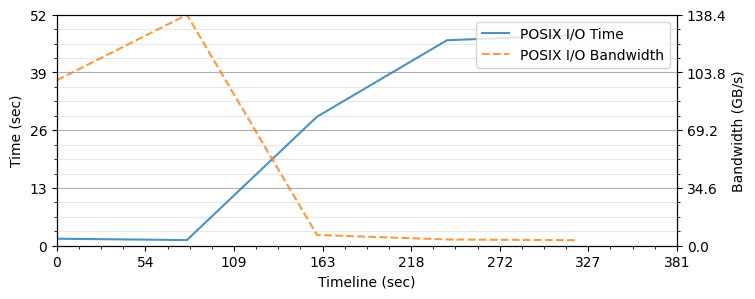

In [14]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit="gb",
    figsize=(8, 3),
    line1_label="POSIX I/O Time",
    line2_label="POSIX I/O Bandwidth",
    time_col="io_time",
    x_num_ticks=8,
    y_num_ticks=5,
)

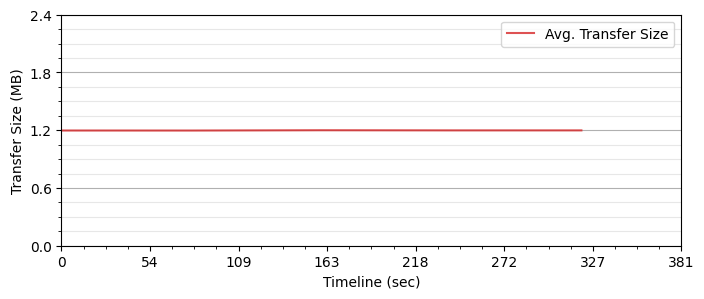

In [15]:
fig, ax = analyzer.plots.xfer_size_timeline(
    figsize=(8, 3),
    unit="mb",
    x_num_ticks=8,
)